In [43]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [44]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/sfilatov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sfilatov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [117]:
raw_text = open('../lolita.txt', 'rb').read()
from nltk.tokenize import RegexpTokenizer

SIZE = 1000
sentences = []

sent_text = nltk.sent_tokenize(raw_text.decode("windows-1251"))
for sentence in sent_text:
    tokenized_text = nltk.word_tokenize(sentence)
#     tagged = nltk.pos_tag(tokenized_text)
    sentences.append(tokenized_text)

# skip intro
intro = 30
sentences = sentences[intro:SIZE+intro]

In [118]:
res = set()
for s in sentences:
  for w in s:
    res.add(w)
    
res.add('<S>')
res.add('<E>')
L = len(res)
wtoi = {w:i for i,w in enumerate(list(res))}
itow = {i:w for w,i in wtoi.items()}
start = wtoi['<S>']
vocab_size = len(itow)

In [119]:
N = torch.zeros((L, L), dtype=torch.int32)
for s in sentences:
  ws = ['<S>'] + list(s) + ['<E>']
  for w1, w2 in zip(ws, ws[1:]):
    ix1 = wtoi[w1]
    ix2 = wtoi[w2]
    N[ix1, ix2] += 1

In [120]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(sentences):  
  X, Y = [], []
  for s in sentences:

      context = [start] * block_size
      for w in s + ['<E>']:
        ix = wtoi[w]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(sentences)
n1 = int(0.8*len(sentences))
n2 = int(0.9*len(sentences))

Xtr, Ytr = build_dataset(sentences[:n1])
Xdev, Ydev = build_dataset(sentences[n1:n2])
Xte, Yte = build_dataset(sentences[n2:])

torch.Size([20754, 3]) torch.Size([20754])
torch.Size([2534, 3]) torch.Size([2534])
torch.Size([2819, 3]) torch.Size([2819])


In [130]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True



1956462


In [131]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  20000: 9.1149
   1000/  20000: 7.4046
   2000/  20000: 6.3019
   3000/  20000: 5.9148
   4000/  20000: 5.8966
   5000/  20000: 6.1700
   6000/  20000: 5.3968
   7000/  20000: 5.0964
   8000/  20000: 5.6497
   9000/  20000: 3.8356
  10000/  20000: 4.8620
  11000/  20000: 4.7293
  12000/  20000: 4.5014
  13000/  20000: 5.2430
  14000/  20000: 4.6874
  15000/  20000: 4.3035
  16000/  20000: 4.8390
  17000/  20000: 4.0329
  18000/  20000: 4.6153
  19000/  20000: 4.3821


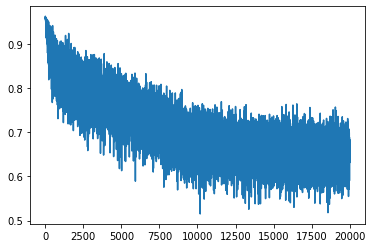

In [123]:
plt.plot(lossi)

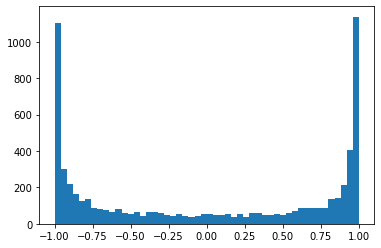

In [124]:
plt.hist(h.view(-1).tolist(), 50);

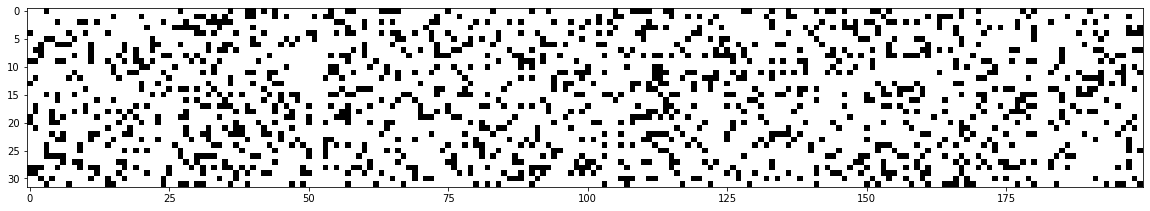

In [125]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.5, cmap='gray', interpolation='nearest')

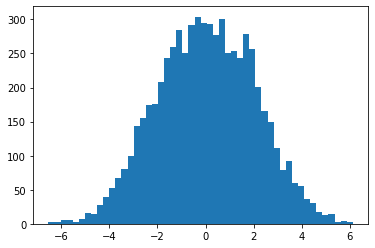

In [126]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [127]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [128]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
#   hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 4.394471168518066
val 7.187750339508057


In [129]:
for _ in range(5):
    
    out = []
    context = [start] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      w = itow[ix]
      if w in ['<E>', '<S>']:
        break
      if w not in [',', '.', '?', '!']:
        out.append(' ')
      out.append(w)
    
    print(''.join(out))
    print('\n')

 Ошан потребовалось членов глуп Снилась печи головой переходит дает мерзкий тому Были искусство Ликование мужская затейливости щебеночным моими Увы левом была терзаний избранниц дому урона лошади очертаний хотел теткой сами состава скользили экспертов мне той некоему хандре волшебством гитана Мак-Фатум человеколюбие окунуть кинопленке бесстыдник счастливых например нехитрыми мускулистому большая пыточной обычным вынося pot-au-feu свободы скатерть фальшивым моем зова плохие лежит


 9 теткой притереться тайну округа встречаются вернулся кто здоровым крови Моникой плотная нынче начала полагаю


 Она представила У солнечной сеть ехал поезде такое эта общую вселенной осторожнейших тысяча лысую завтра кинокартины прерывистый покуда песке влетают продолжая молодой dixhuit том понравились исходное ног экспресса труды роковое вместе плюше нечаянно примерами вода чутьем мое силах устремленных жалкое там воспаление закатить была энергией трость отъездом подвале всякого дрожью отвезти бледных бух

In [150]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
#   layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


1079104


In [151]:
# same optimization as last time
max_steps = 10000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 7500 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/  10000: 9.1597
   1000/  10000: 8.0469
   2000/  10000: 8.0082
   3000/  10000: 5.6089
   4000/  10000: 6.2882
   5000/  10000: 7.7648
   6000/  10000: 6.4686
   7000/  10000: 6.4863
   8000/  10000: 6.9273
   9000/  10000: 6.6675


layer 2 (      Tanh): mean -0.00, std 0.66, saturated: 5.53%
layer 5 (      Tanh): mean +0.01, std 0.68, saturated: 6.56%
layer 8 (      Tanh): mean -0.01, std 0.68, saturated: 6.44%
layer 11 (      Tanh): mean +0.01, std 0.68, saturated: 5.78%
layer 14 (      Tanh): mean -0.01, std 0.66, saturated: 4.59%


Text(0.5, 1.0, 'activation distribution')

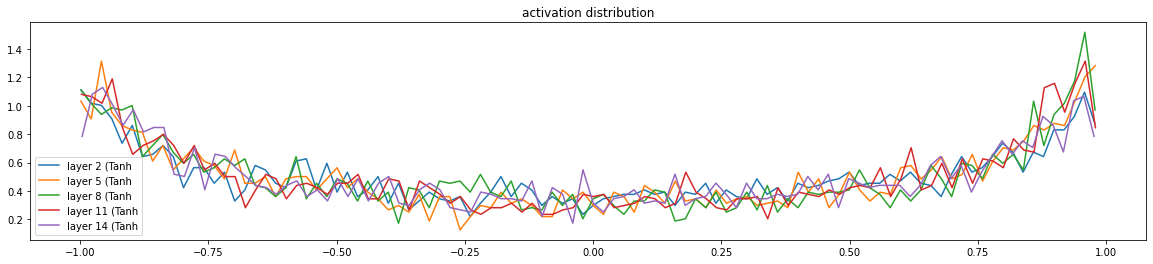

In [152]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 4.167997e-03
layer 5 (      Tanh): mean +0.000000, std 4.244718e-03
layer 8 (      Tanh): mean +0.000000, std 4.192283e-03
layer 11 (      Tanh): mean -0.000000, std 3.892716e-03
layer 14 (      Tanh): mean -0.000000, std 3.561424e-03


Text(0.5, 1.0, 'gradient distribution')

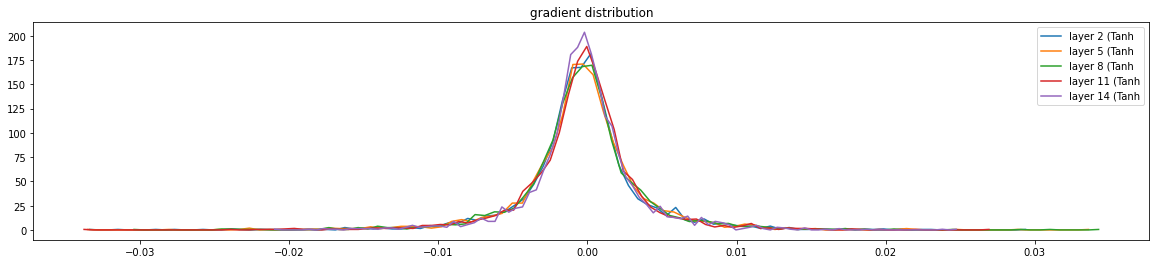

In [153]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight (9242, 10) | mean +0.000000 | std 7.617701e-04 | grad:data ratio 7.606423e-04
weight  (30, 100) | mean +0.000054 | std 1.457515e-02 | grad:data ratio 6.785380e-02
weight (100, 100) | mean +0.000004 | std 9.794945e-03 | grad:data ratio 7.602763e-02
weight (100, 100) | mean +0.000047 | std 1.008154e-02 | grad:data ratio 7.933117e-02
weight (100, 100) | mean -0.000011 | std 9.334594e-03 | grad:data ratio 7.416961e-02
weight (100, 100) | mean -0.000097 | std 9.147410e-03 | grad:data ratio 7.416533e-02
weight (100, 9242) | mean +0.000000 | std 9.838896e-04 | grad:data ratio 9.814908e-03


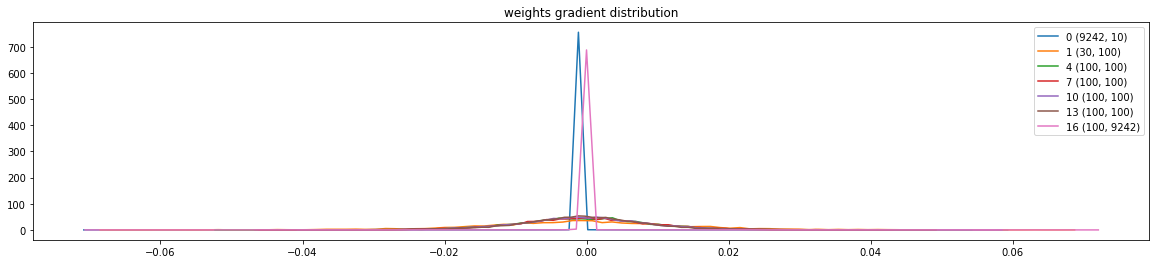

In [154]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

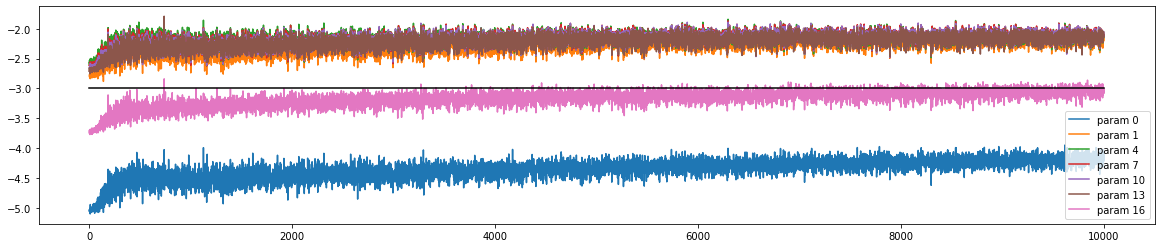

In [155]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [156]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 6.492766380310059
val 7.014041900634766


In [157]:
for _ in range(5):
    
    out = []
    context = [start] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      w = itow[ix]
      if w in ['<E>', '<S>']:
        break
      if w not in [',', '.', '?', '!']:
        out.append(' ')
      out.append(w)
    
    print(''.join(out))
    print('\n')

 детский Чудесная пользовался извлекаемые колену Ощущение сундук глянцевито-голубых прозы робок которым столиком Бостон стены далекое парижском указания Новую теплые сливовой косточка посмертных въезжает темно-коричневое подбородок До платьице вести велосипеде крыжовенным летнем ветхости месяц сцену гаже тела негр уединении уюта 1882-ом рядов подражание какой окружен Годы сям изуродованный могу сошли объяснить известных детям мексиканским толстый пляжную припомнить здорового дог провал Дамор-Блок – фирме смуглой моя девочек именно ослепляет долларов занималась детской месте подарок каким письма отозвался Визави, взмахнул Драматурге мирного дочками даст всей вся добавочным Кстати mon перейдем делами Мороженое лишь отъедет строгим внушительно Калифорнию оттенок присоединились беленый выкручивают


 Она ролика решил Повисая время безумный Мельвильском Данте нарушая благодушного материях интересный нежном безумный знака смехотворная сердитая другим пыхтя Этого нелегкая род Нью-Йорка выдумы